# Core Workflow: Training Models
Compiles "superset" of training data by loading stored training data from specified places & images. This data is then used to train two models: a SVM and a dense neural network. These objects as well as the associated data scaler are saved to file.
  
Date: 2018-09-13  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

tile_resolution = resolution
tile_size = 256
tile_pad = 16

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

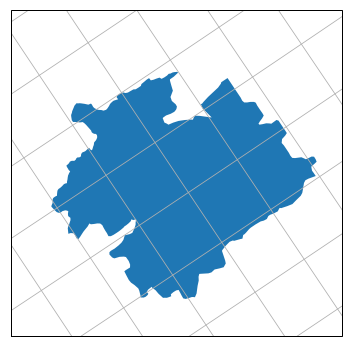

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.1775006012039, 17.529165535205387], [78.20460181878519, 17.52954978485592], [78.20420289377427, 17.555551127046854], [78.17709782110293, 17.55516627151902], [78.1775006012039, 17.529165535205387]]]}


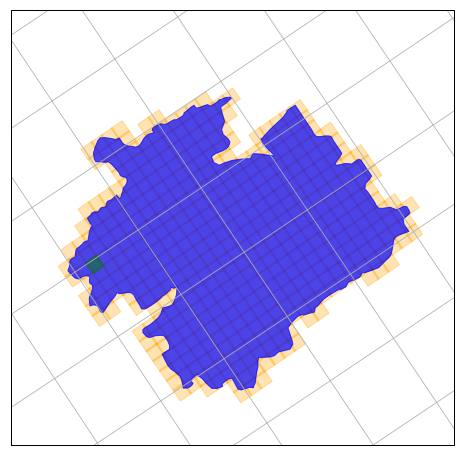

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Specify training data & training parameters

In [5]:
window = 7    # width of square window

cats_map = {}
cats_map[0] = 0
cats_map[1] = 1
cats_map[2] = 4
cats_map[3] = 4
cats_map[4] = 4
cats_map[5] = 4
cats_map[6] = 6

bands_vir=bands[:-1]
bands_sar=s1_bands
bands_ndvi=None
bands_ndbi=None
bands_osm=None

haze_removal = False


epochs = 100
batch_size = 128
balancing = None
model_id = 'phase_iii_demo_5'
notes = 'testing workflow modified to preserve full AUE taxonomy in training data files'

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Build training data "superset"
The "superset" of training data used to actually train a model can be a combination of any number of stored training data sets built from particular input stacks. These constituent sets can come from one or many cities. The only requirement is that they are all consistent in construction, ie are built from the same input stack.

In [7]:
place_images = {}
place_images['hyderabad'] = ['A']

X_train, Y_train_raw, X_valid, Y_valid_raw = util_workflow.load_datasets(place_images, data_root, label_suffix, stack_label, window)

calculate total size of training and validation supersets
/data/phase_iii/hyderabad/hyderabad_train_aue_vir+sar_7w_A.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_vir+sar_7w_A.pkl
(64355, 392) (64355,) (27582, 392) (27582,)
64355 27582
construct np arrays for supersets
populate superset np arrays
/data/phase_iii/hyderabad/hyderabad_train_aue_vir+sar_7w_A.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_vir+sar_7w_A.pkl
(64355, 392) (64355,) (27582, 392) (27582,)
(64355, 392) (64355,)


### Prepare training data for ingestion
This version of the workflow does not include class-balancing

Remap original set of categories (from the Atlas of Urban Expansion) encoded in the ground-truth files and the training data files to a target typology (eg collapsing all residential LULC types to a single category)

In [8]:
Y_train = Y_train_raw.copy()
Y_valid = Y_valid_raw.copy()

for k, v in cats_map.items():
    Y_train[Y_train_raw==k] = v
    Y_valid[Y_valid_raw==k] = v
    
del Y_train_raw, Y_valid_raw

Now reduce the remapped values to the categorical values required by the Keras library. These pre-processing steps could be consolidated, but represent two separate conceptual parts of the workflow, so are executed separately

In [9]:
Y_t = Y_train.copy()
Y_v = Y_valid.copy()

Y_t[Y_train==0] = 0
Y_t[Y_train==1] = 1
Y_t[Y_train==4] = 2
Y_t[Y_train==6] = 3

Y_v[Y_valid==0] = 0
Y_v[Y_valid==1] = 1
Y_v[Y_valid==4] = 2
Y_v[Y_valid==6] = 3

categories_reduced = [0,1,2,3]

Y_t_cat = to_categorical(Y_t)
Y_v_cat = to_categorical(Y_v)

### Scale training data

In [11]:
X_train_scaled, X_valid_scaled, scaler = util_ml.scale_learning_data(X_train, X_valid)
print X_train_scaled.shape, Y_t.shape

(64355, 392) (27582, 392)
(64355, 392) (64355,)


### Train SVM

In [12]:
Yhat_train, Yhat_valid, model = util_ml.train_model_svm(X_train_scaled, X_valid_scaled, Y_t, Y_v, categories=categories_reduced)

evaluate training
0 17168
1 13526
2 24426
3 9235
[[13194  1031  2589   354]
 [ 4354  1332  7277   563]
 [ 1668   975 21436   347]
 [ 1882   522  6215   616]]
64355 36578 0.5683785253671043
evaluate validation
0 7335
1 5695
2 10658
3 3894
[[5668  446 1075  146]
 [1971  505 2990  229]
 [ 779  414 9328  137]
 [ 782  222 2657  233]]
27582 15734 0.5704444927851497


### Build and train dense neural network

In [13]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)))
network.add(Dropout(0.2))
network.add(layers.Dense(256, activation='relu'))
network.add(Dropout(0.2))
network.add(layers.Dense(len(categories_reduced), activation='softmax'))
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [14]:
network.fit(X_train_scaled, Y_t_cat, epochs=epochs, batch_size=batch_size)

Epoch 1/100
64355/64355 [==============================] - 3s 51us/step - loss: 0.9958 - acc: 0.6085
Epoch 2/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.8949 - acc: 0.6471
Epoch 3/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.8491 - acc: 0.6669
Epoch 4/100
64355/64355 [==============================] - 2s 38us/step - loss: 0.8137 - acc: 0.6807
Epoch 5/100
64355/64355 [==============================] - 2s 38us/step - loss: 0.7831 - acc: 0.6929
Epoch 6/100
64355/64355 [==============================] - 2s 39us/step - loss: 0.7555 - acc: 0.7051
Epoch 7/100
64355/64355 [==============================] - 2s 39us/step - loss: 0.7295 - acc: 0.7134
Epoch 8/100
64355/64355 [==============================] - 3s 39us/step - loss: 0.7041 - acc: 0.7243
Epoch 9/100
64355/64355 [==============================] - 2s 37us/step - loss: 0.6848 - acc: 0.7321
Epoch 10/100
64355/64355 [==============================] - 2s 37us/step - loss: 0.6686 - a

64355/64355 [==============================] - 2s 36us/step - loss: 0.3448 - acc: 0.8772
Epoch 82/100
64355/64355 [==============================] - 2s 37us/step - loss: 0.3453 - acc: 0.8769
Epoch 83/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.3488 - acc: 0.8766
Epoch 84/100
64355/64355 [==============================] - 2s 37us/step - loss: 0.3449 - acc: 0.8785
Epoch 85/100
64355/64355 [==============================] - 2s 37us/step - loss: 0.3437 - acc: 0.8788
Epoch 86/100
64355/64355 [==============================] - 2s 37us/step - loss: 0.3480 - acc: 0.8776
Epoch 87/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.3446 - acc: 0.8802
Epoch 88/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.3457 - acc: 0.8801
Epoch 89/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.3358 - acc: 0.8810
Epoch 90/100
64355/64355 [==============================] - 2s 36us/step - loss: 0.3381 - acc: 

In [15]:
print "evaluate training"
Yhat_t_prob = network.predict(X_train_scaled)
Yhat_t = Yhat_t_prob.argmax(axis=-1)
train_confusion = util_ml.calc_confusion(Yhat_t,Y_t,categories_reduced)
train_recalls, train_precisions, train_accuracy = util_ml.calc_confusion_details(train_confusion)

print "evaluate validation"
Yhat_v_prob = network.predict(X_valid_scaled)
Yhat_v = Yhat_v_prob.argmax(axis=-1)
valid_confusion = util_ml.calc_confusion(Yhat_v,Y_v,categories_reduced)
valid_recalls, valid_precisions, valid_accuracy = util_ml.calc_confusion_details(valid_confusion)

evaluate training
0 17168
1 13526
2 24426
3 9235
[[16693    99   220   156]
 [  279 12836   220   191]
 [   19    12 24346    49]
 [  235    89   750  8161]]
64355 62036 0.963965503845855
evaluate validation
0 7335
1 5695
2 10658
3 3894
[[6299  290  461  285]
 [ 513 3935  794  453]
 [ 235  266 9587  570]
 [ 341  377 1360 1816]]
27582 21637 0.7844608802842433


### Store and track model objects

In [16]:
reload(util_workflow)

scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'_DLv3.hd5'

if os.path.exists(scaler_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+scaler_filename+')'
elif os.path.exists(model_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+model_filename+')'
elif os.path.exists(network_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+network_filename+')'
else:
    print scaler_filename
    print model_filename
    print network_filename
    pickle.dump(scaler, open(scaler_filename, 'wb'))
    pickle.dump(model, open(model_filename, 'wb'))
    network.save(network_filename)
    # tracking only occurs if all saves are successful
    util_workflow.record_model_creation(
        model_id, notes, place_images, label_suffix, resolution, stack_label, feature_count, window, cats_map, balancing, 
        network.get_config(), epochs, batch_size,
        train_confusion, train_recalls, train_precisions, train_accuracy, 
        valid_confusion, valid_recalls, valid_precisions, valid_accuracy,)
    

/data/phase_iii/models/phase_iii_demo_5_scaler.pkl
/data/phase_iii/models/phase_iii_demo_5_SVM.pkl
/data/phase_iii/models/phase_iii_demo_5_DLv3.hd5
